# Aggregated dataset

We group the incidents that happened in the same congressional district of each state: label [state, congressional district] (and eventually in the same year, month).

We consider the numerical features of the dataset df_incidents:
- the mean of 'avg_age_participants'
- the sum of the features 'n_participants_child'-'n_participants'

We also add the 'povertyPercentage' feature of df_poverty for each state, year.

Finally, given the year of the incident, we add the 'party', 'candidatevotes', 'totalvotes' features from the dataset df_elections for each [state, congressional district].

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [34]:
df_incidents = pd.read_csv('../datasets_clean/incidents_clean.csv')
df_elections = pd.read_csv('../datasets_clean/elections_clean.csv')
df_poverty = pd.read_csv('../datasets_clean/poverty_clean.csv')

In [35]:
df_incidents.head()

,Unnamed: 0,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,...,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year
0,0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,...,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,2015.0
1,1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,...,1.0,1.0,0.0,1,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",2017.0
2,3,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,...,1.0,1.0,0.0,0,1,0.0,0.0,2.0,Shot - Wounded/Injured,2016.0
3,5,2014-01-18,North Carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,...,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,2014.0
4,6,2018-01-25,Louisiana,Zachary,18733 Samuels Rd,30.6069,-91.2270,6.0,26.0,0.0,...,5.0,5.0,0.0,2,1,2.0,0.0,5.0,Shot - Wounded/Injured,2018.0


In [36]:
df_elections.head()

,Unnamed: 0,year,state,congressional_district,party,candidatevotes,totalvotes
0,0,1976,ALABAMA,1,REPUBLICAN,98257.0,157170.0
1,1,1976,ALABAMA,2,REPUBLICAN,90069.0,156362.0
2,2,1976,ALABAMA,3,DEMOCRAT,106935.0,108048.0
3,3,1976,ALABAMA,4,DEMOCRAT,141490.0,176022.0
4,4,1976,ALABAMA,5,DEMOCRAT,113553.0,113560.0


In [37]:
df_poverty.head()

,Unnamed: 0,state,year,povertyPercentage,population
0,0,United States,2019,11.2,328239523
1,1,Alabama,2019,14.5,4903185
2,2,Alaska,2019,11.7,731545
3,3,Arizona,2019,11.2,7278717
4,4,Arkansas,2019,15.1,3017804


In [38]:
df_incidents['date'] = pd.to_datetime(df_incidents['date'])

In [39]:
df_incidents['year_month'] = df_incidents['date'].dt.strftime('%Y-%m')

In [40]:
# aggregated dataset creation
# n. of incidents per districts and month
df_incidents_agg = df_incidents.groupby(['state', 'congressional_district', 'year_month']).size().reset_index(name='n_incidents')
df_incidents_agg.head()

,state,congressional_district,year_month,n_incidents
0,Alabama,1.0,2014-01,7
1,Alabama,1.0,2014-02,10
2,Alabama,1.0,2014-03,7
3,Alabama,1.0,2014-04,8
4,Alabama,1.0,2014-05,13


In [41]:
# aggregated dataset creation
# n. of incidents per districts and month
df_incidents_agg = df_incidents.groupby(['state', 'congressional_district', 'year_month']).size().reset_index(name='n_incidents')
df_incidents_agg.head()
df_incidents_agg['n_participants'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_participants'].sum().reset_index(name='n_participants')['n_participants']
df_incidents_agg['n_killed'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_killed'].sum().reset_index(name='n_killed')['n_killed']
df_incidents_agg['n_injured'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_injured'].sum().reset_index(name='n_injured')['n_injured']
df_incidents_agg['n_unharmed'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_unharmed'].sum().reset_index(name='n_unharmed')['n_unharmed']
df_incidents_agg['n_participants_child'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_participants_child'].sum().reset_index(name='n_participants_child')['n_participants_child']
df_incidents_agg['n_participants_teen'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_participants_teen'].sum().reset_index(name='n_participants_teen')['n_participants_teen']
df_incidents_agg['n_participants_adult'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_participants_adult'].sum().reset_index(name='n_participants_adult')['n_participants_adult']
df_incidents_agg['avg_age_participants'] = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['avg_age_participants'].mean().reset_index(name='avg_age_participants')['avg_age_participants']


In [42]:

# year and month
df_incidents_agg['year'] = df_incidents_agg['year_month'].str.split('-').str[0]
df_incidents_agg['month'] = df_incidents_agg['year_month'].str.split('-').str[1]
df_incidents_agg['year'] = df_incidents_agg['year'].astype('int64')
df_incidents_agg['month'] = df_incidents_agg['month'].astype('int64')
df_incidents_agg = df_incidents_agg.drop(columns=['year_month'])


In [43]:
df_incidents_agg['state'] = df_incidents_agg['state'].str.lower()

# join with elections on state and congressional district
df_elections['state'] = df_elections['state'].str.lower()
df_elections['year'] = df_elections['year'].astype('int64')
df_incidents_agg = pd.merge(df_incidents_agg, df_elections, on=['state', 'congressional_district', 'year'], how='left')


In [44]:

# join with poverty on state and year
df_poverty['year'] = df_poverty['year'].astype('int64')
df_poverty['state'] = df_poverty['state'].str.lower()
df_incidents_agg = pd.merge(df_incidents_agg, df_poverty, on=['state', 'year'], how='left')
df_incidents_agg


,state,congressional_district,n_incidents,n_participants,n_killed,n_injured,n_unharmed,n_participants_child,n_participants_teen,n_participants_adult,avg_age_participants,year,month,Unnamed: 0_x,party,candidatevotes,totalvotes,Unnamed: 0_y,povertyPercentage,population
0,alabama,1.0,7,21.0,3,2,13.0,0.0,3.0,11.0,30.857143,2014,1,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
1,alabama,1.0,10,16.0,5,3,7.0,0.0,0.0,15.0,27.900000,2014,2,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
2,alabama,1.0,7,21.0,3,1,11.0,1.0,1.0,19.0,29.428571,2014,3,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
3,alabama,1.0,8,15.0,3,3,8.0,0.0,2.0,10.0,27.875000,2014,4,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
4,alabama,1.0,13,23.0,7,3,11.0,0.0,4.0,18.0,27.538462,2014,5,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21112,wyoming,1.0,7,12.0,0,2,3.0,0.0,0.0,11.0,37.285714,2017,5,NaN,NaN,NaN,NaN,155,10.5,578931
21113,wyoming,1.0,12,14.0,0,2,0.0,0.0,0.0,14.0,34.083333,2017,6,NaN,NaN,NaN,NaN,155,10.5,578931
21114,wyoming,1.0,1,1.0,0,0,0.0,0.0,0.0,1.0,26.000000,2017,7,NaN,NaN,NaN,NaN,155,10.5,578931
21115,wyoming,1.0,6,9.0,3,2,0.0,0.0,0.0,9.0,42.333333,2017,8,NaN,NaN,NaN,NaN,155,10.5,578931


In [45]:

# fill the missing values of 'party', 'candidatevotes', 'totalvotes' with data from the previous year, same state and same congressional district
def fill_with_previous_year(row):
    if pd.isnull(row['party']):
        # find the previous year
        previous_year = row['year']-1
        # find the previous row
        previous_row = df_incidents_agg[(df_incidents_agg['state']==row['state']) & (df_incidents_agg['congressional_district']==row['congressional_district']) & (df_incidents_agg['year']==previous_year)]
        if previous_row.shape[0]>0:
            # fill the missing values with the values of the previous row
            row['party'] = previous_row['party'].values[0]
            row['candidatevotes'] = previous_row['candidatevotes'].values[0]
            row['totalvotes'] = previous_row['totalvotes'].values[0]
        elif row['congressional_district']==0:
            # fill with the sum of the values of the same state, previous year
            previous_rows = df_incidents_agg[(df_incidents_agg['state']==row['state']) & (df_incidents_agg['year']==previous_year)]
            if previous_rows.shape[0]>0:
                row['candidatevotes'] = previous_rows['candidatevotes'].sum()
                row['totalvotes'] = previous_rows['totalvotes'].sum()
    return row
# apply the function to the dataframe
df_incidents_agg = df_incidents_agg.apply(fill_with_previous_year, axis=1)


In [46]:
df_incidents_agg

,state,congressional_district,n_incidents,n_participants,n_killed,n_injured,n_unharmed,n_participants_child,n_participants_teen,n_participants_adult,avg_age_participants,year,month,Unnamed: 0_x,party,candidatevotes,totalvotes,Unnamed: 0_y,povertyPercentage,population
0,alabama,1.0,7,21.0,3,2,13.0,0.0,3.0,11.0,30.857143,2014,1,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
1,alabama,1.0,10,16.0,5,3,7.0,0.0,0.0,15.0,27.900000,2014,2,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
2,alabama,1.0,7,21.0,3,1,11.0,1.0,1.0,19.0,29.428571,2014,3,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
3,alabama,1.0,8,15.0,3,3,8.0,0.0,2.0,10.0,27.875000,2014,4,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
4,alabama,1.0,13,23.0,7,3,11.0,0.0,4.0,18.0,27.538462,2014,5,8265.0,REPUBLICAN,103758.0,152234.0,261,16.8,4841799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21112,wyoming,1.0,7,12.0,0,2,3.0,0.0,0.0,11.0,37.285714,2017,5,NaN,NaN,NaN,NaN,155,10.5,578931
21113,wyoming,1.0,12,14.0,0,2,0.0,0.0,0.0,14.0,34.083333,2017,6,NaN,NaN,NaN,NaN,155,10.5,578931
21114,wyoming,1.0,1,1.0,0,0,0.0,0.0,0.0,1.0,26.000000,2017,7,NaN,NaN,NaN,NaN,155,10.5,578931
21115,wyoming,1.0,6,9.0,3,2,0.0,0.0,0.0,9.0,42.333333,2017,8,NaN,NaN,NaN,NaN,155,10.5,578931


<Axes: >

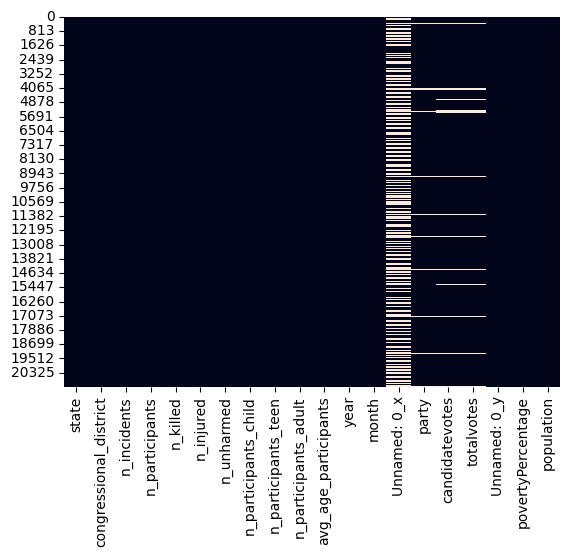

In [47]:
# visualize nan
sns.heatmap(df_incidents_agg.isnull(), cbar=False)


In [51]:
# count nan

# drom unnamed column
df_incidents_agg = df_incidents_agg.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])

In [52]:
df_incidents_agg.isnull().sum()

state                       0
congressional_district      0
n_incidents                 0
n_participants              0
n_killed                    0
n_injured                   0
n_unharmed                  0
n_participants_child        0
n_participants_teen         0
n_participants_adult        0
avg_age_participants        0
year                        0
month                       0
party                     600
candidatevotes            763
totalvotes                763
povertyPercentage           0
population                  0
dtype: int64

In [55]:
# drop year 2013
df_incidents_agg = df_incidents_agg[df_incidents_agg['year']!=2013]

In [56]:
# count nan
df_incidents_agg.isnull().sum()

state                       0
congressional_district      0
n_incidents                 0
n_participants              0
n_killed                    0
n_injured                   0
n_unharmed                  0
n_participants_child        0
n_participants_teen         0
n_participants_adult        0
avg_age_participants        0
year                        0
month                       0
party                     381
candidatevotes            544
totalvotes                544
povertyPercentage           0
population                  0
dtype: int64

## Visualization

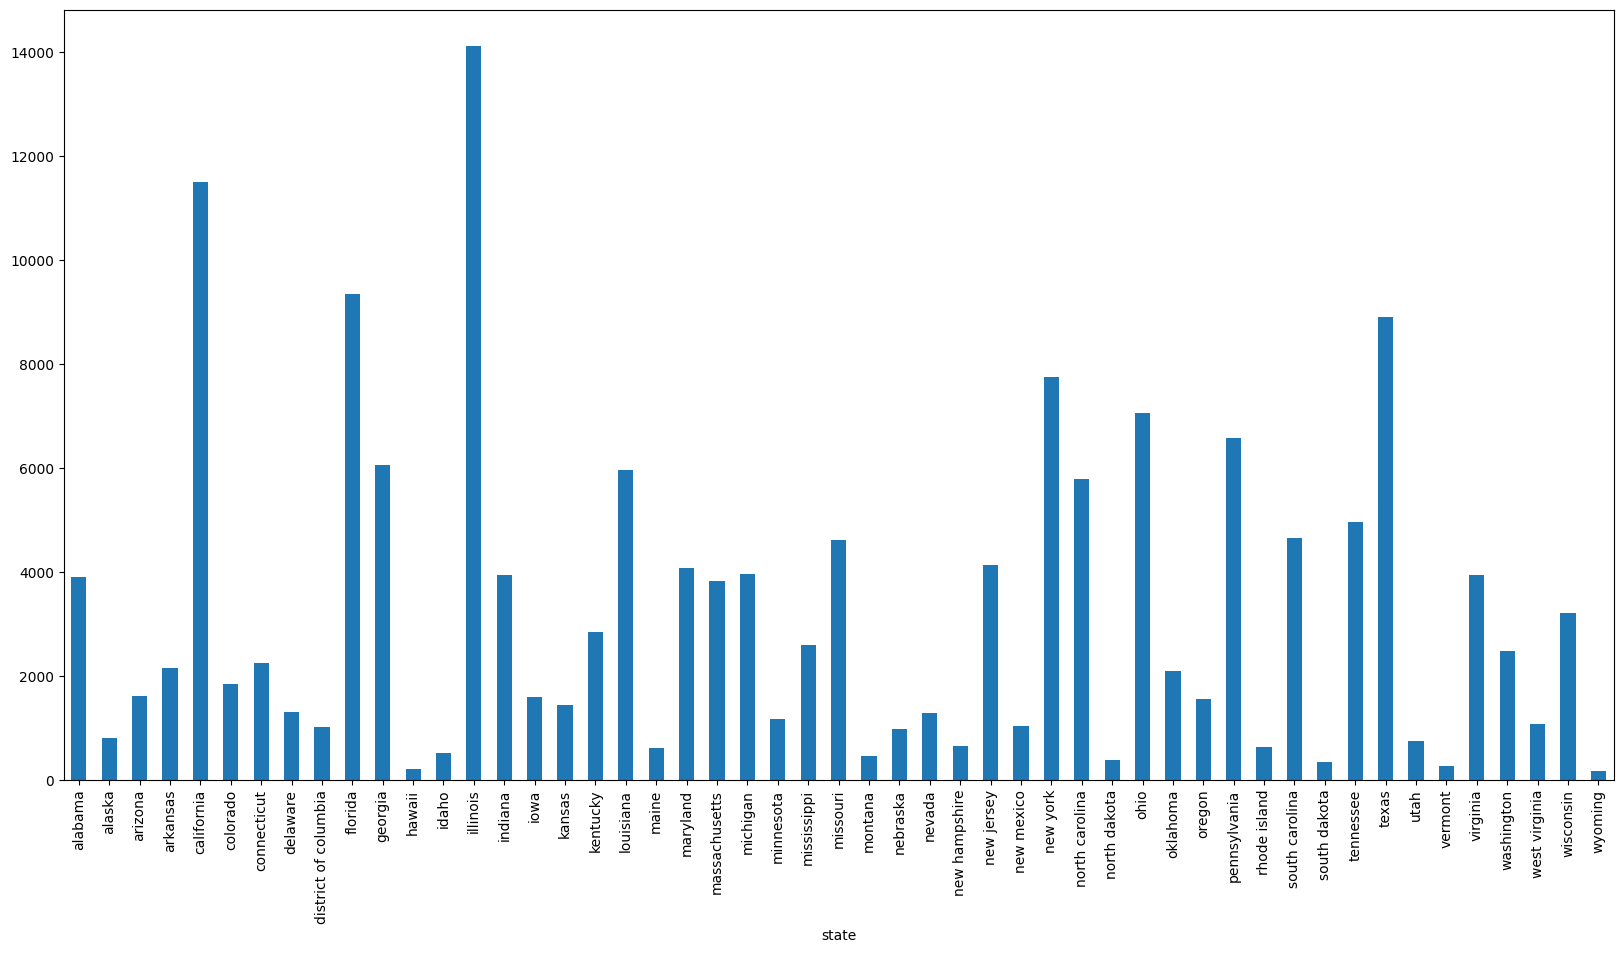

In [61]:
# bar graph of the number of incidents per state
df_incidents_agg.groupby('state')['n_incidents'].sum().plot.bar(figsize=(20,10))
plt.show()


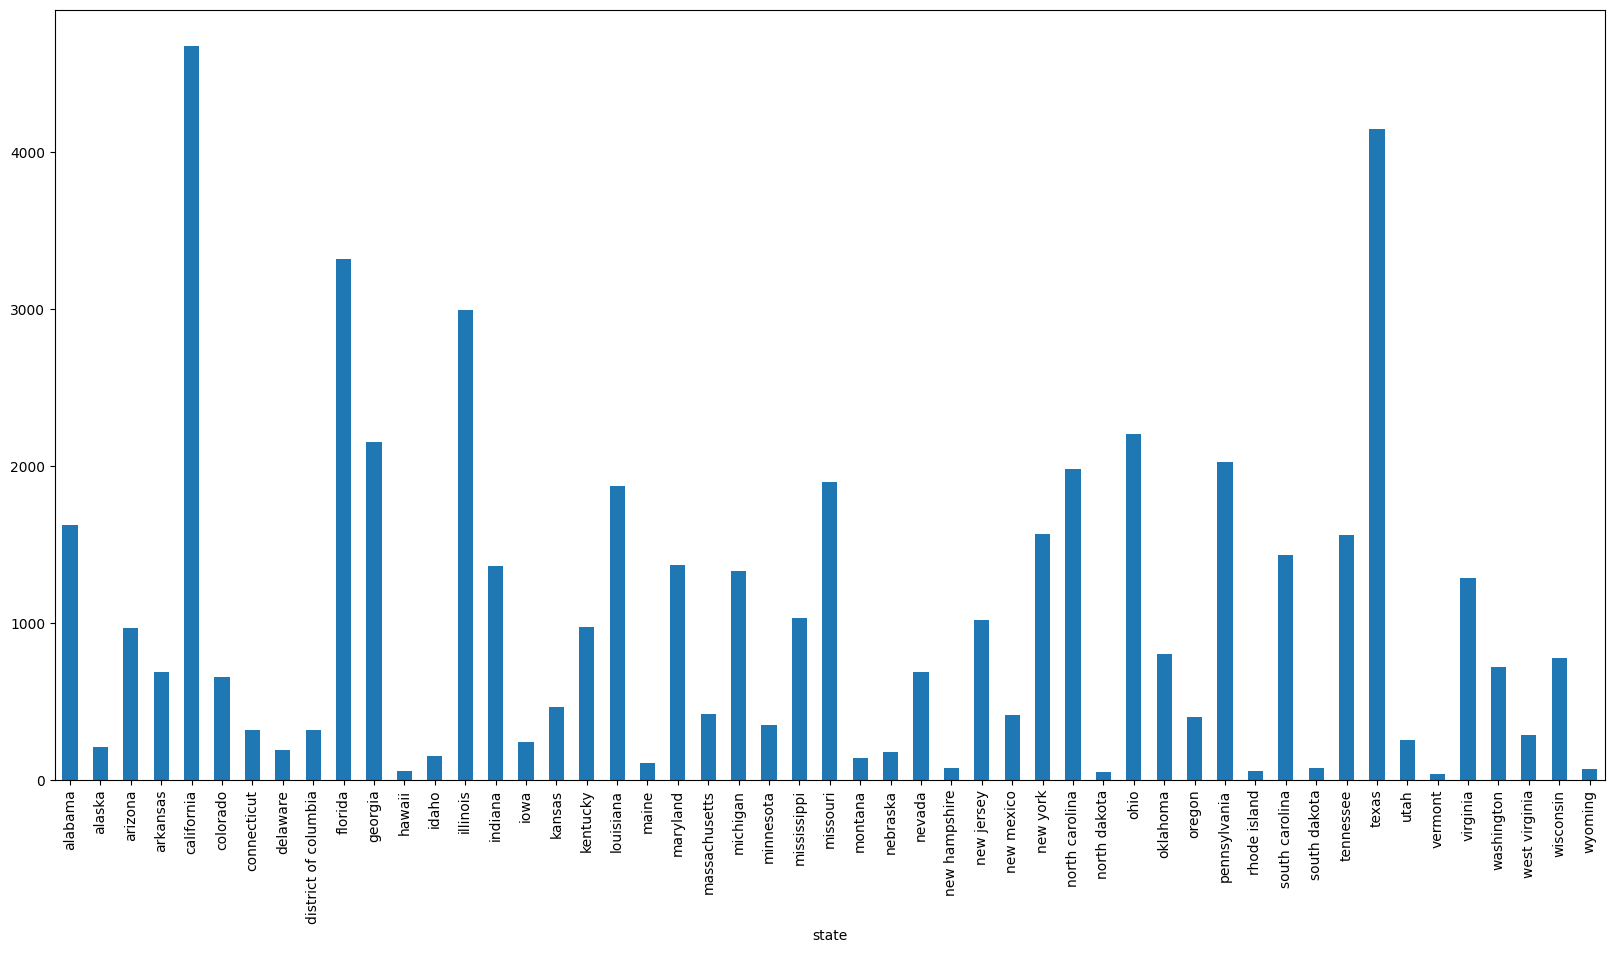

In [62]:
# bar graph of the number of killed per state
df_incidents_agg.groupby('state')['n_killed'].sum().plot.bar(figsize=(20,10))
plt.show()


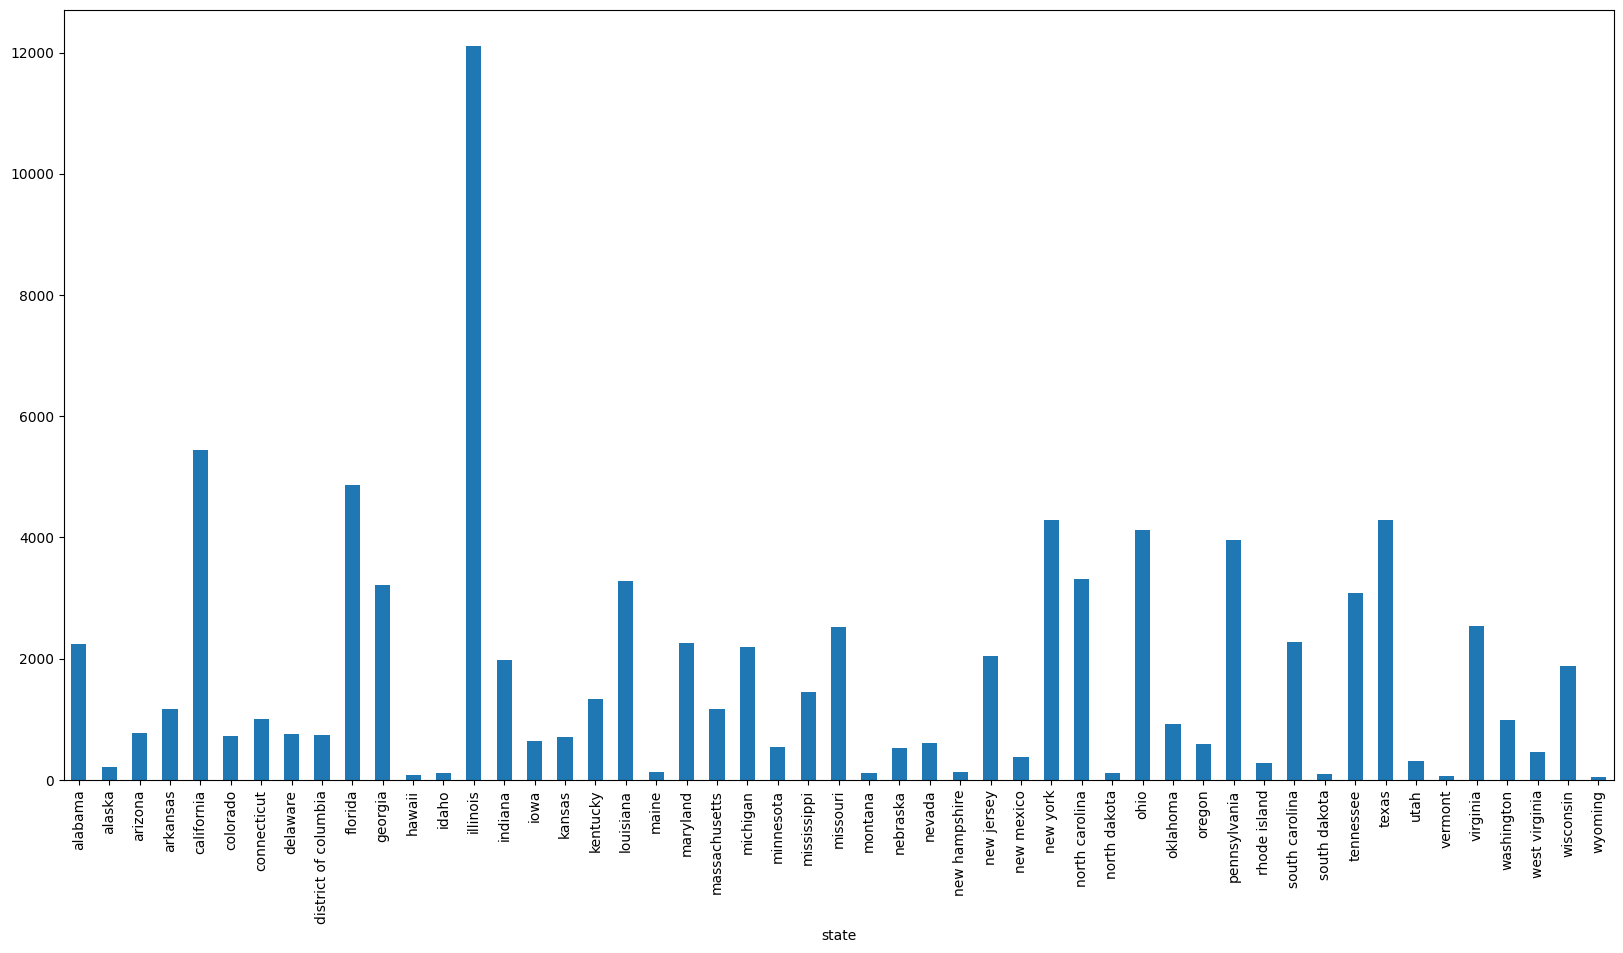

In [63]:
# bar graph of the number of injured per state
df_incidents_agg.groupby('state')['n_injured'].sum().plot.bar(figsize=(20,10))
plt.show()

<Axes: >

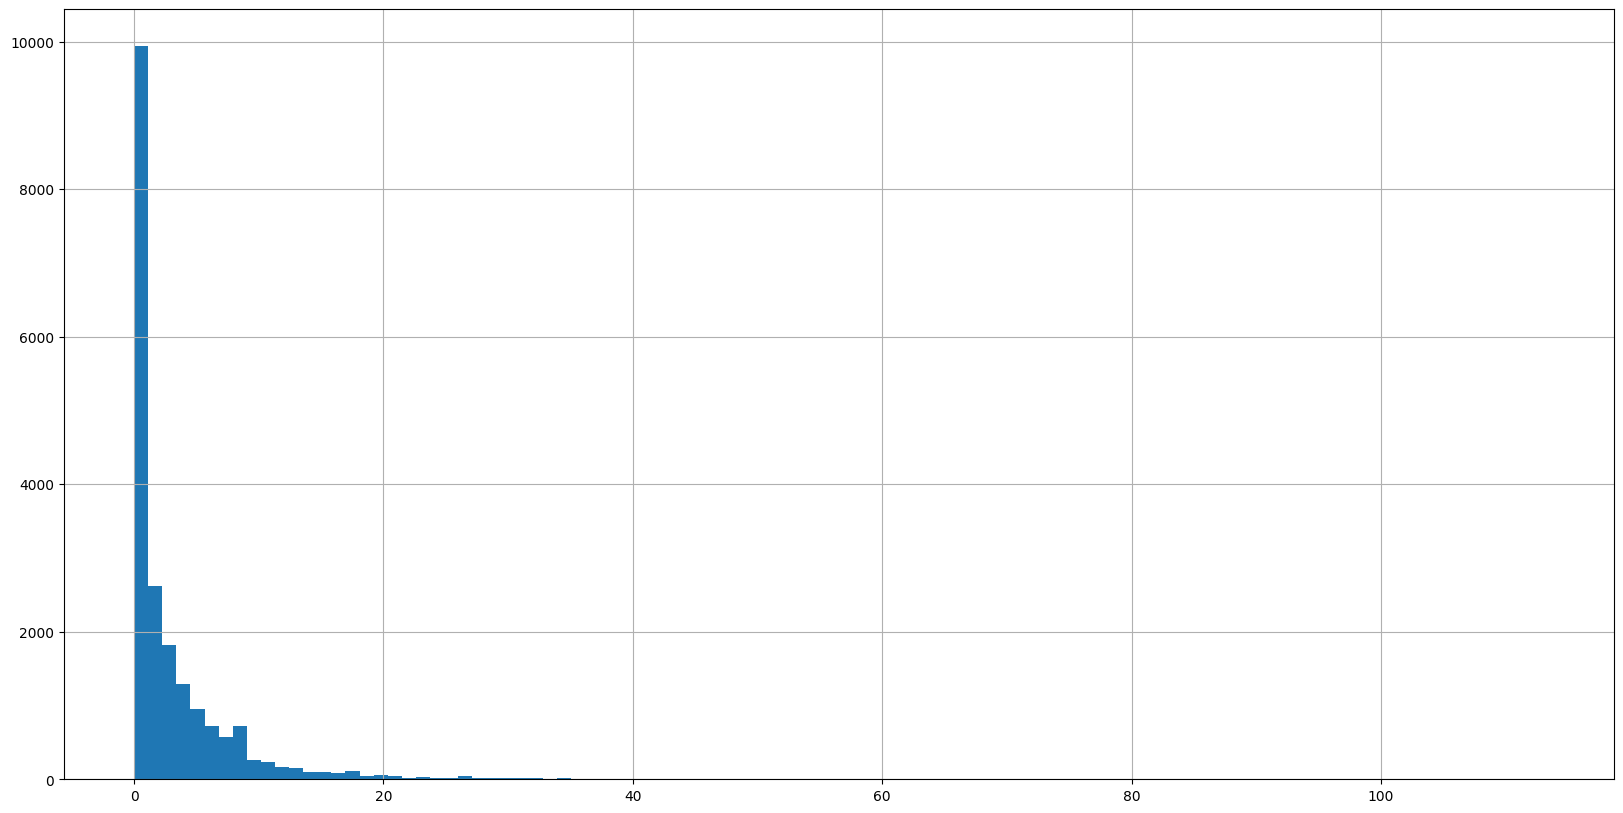

In [106]:
# histogram of the number of incident
df_incidents_agg['n_unharmed'].hist(figsize=(20,10), bins=100)

<Axes: xlabel='month'>

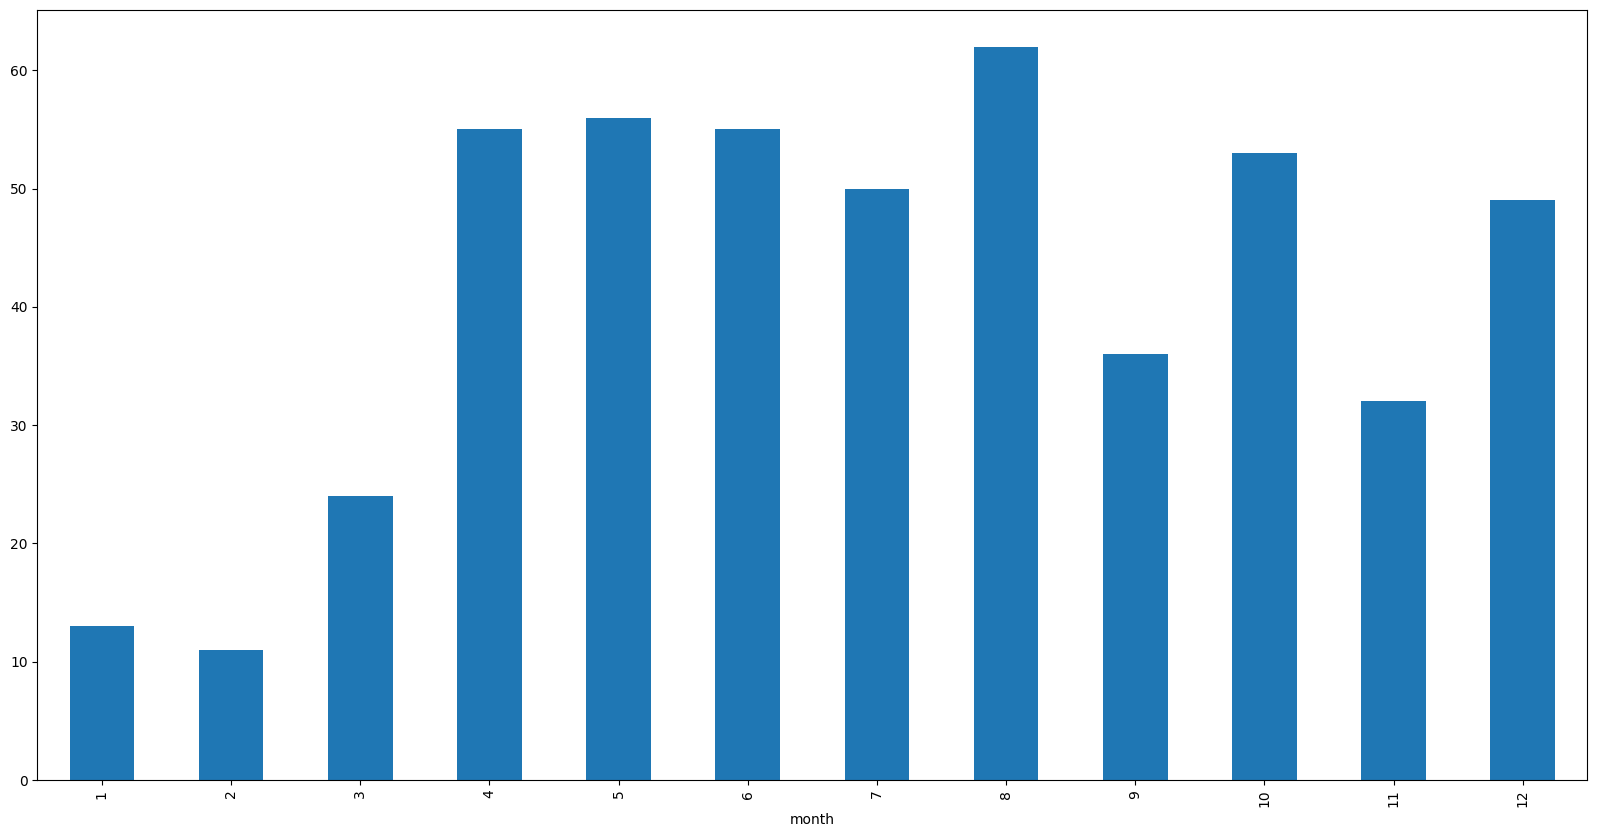

In [71]:
# plot of the number of incidents per month of district 1 of California in 2014
df_incidents_agg[(df_incidents_agg['state']=='illinois') & (df_incidents_agg['congressional_district']==1) & (df_incidents_agg['year']==2014)].groupby('month')['n_incidents'].sum().plot.bar(figsize=(20,10))

<Axes: >

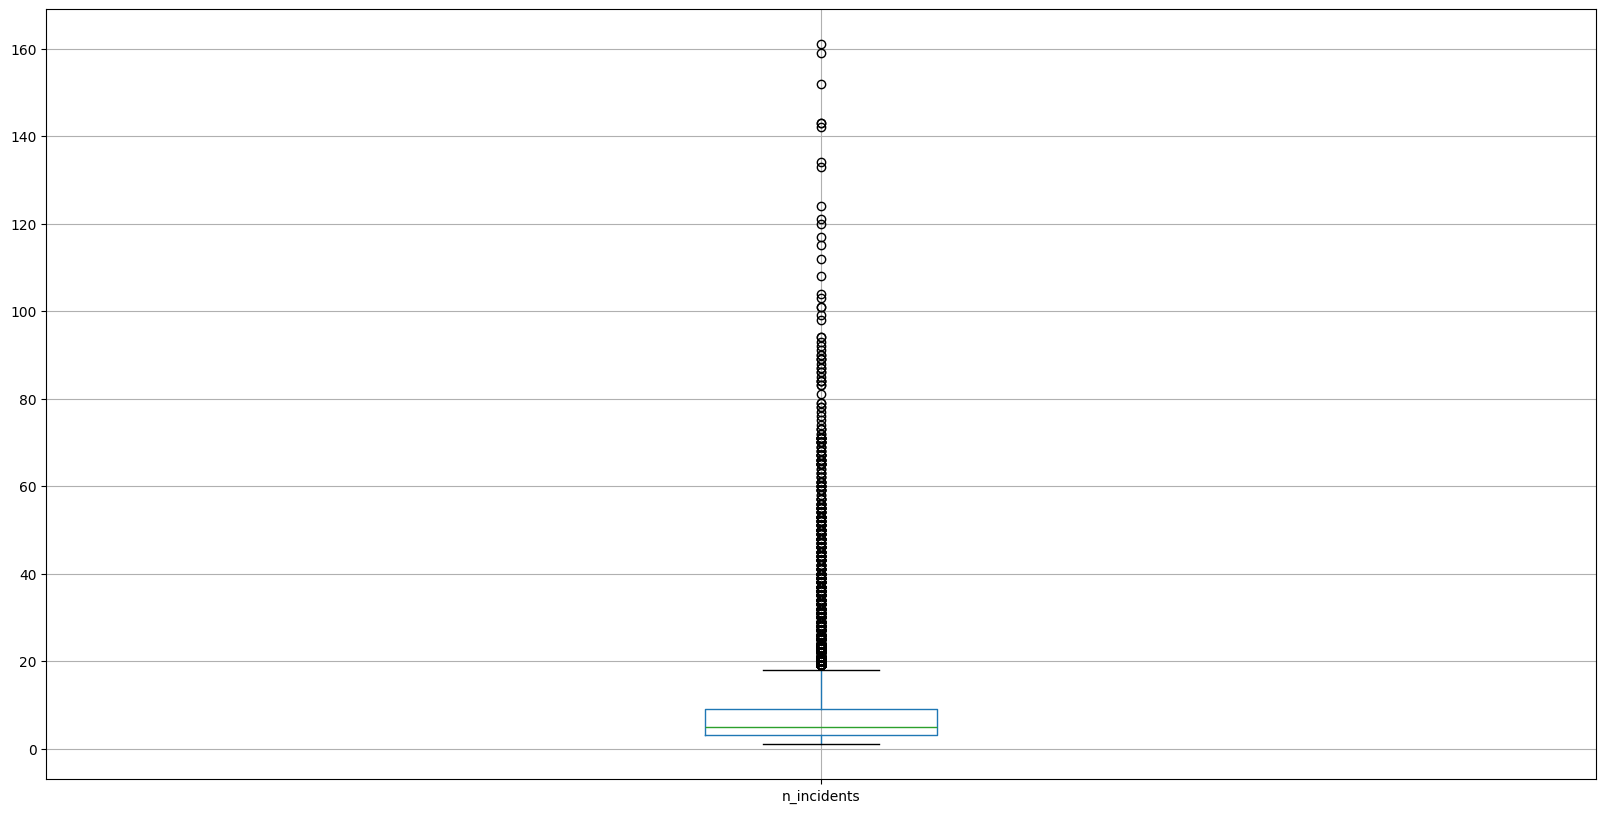

In [109]:
# boxplot of the incidents
df_incidents_agg.boxplot(column=['n_incidents'], figsize=(20,10))

# Clustering

# pca

In [73]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [74]:
# drop nan
df_incidents_agg = df_incidents_agg.dropna()

In [93]:
# pca on numerical features
df_incidents_agg_pca = df_incidents_agg[[ 'n_participants', 'n_killed', 'n_injured', 'n_unharmed', 'n_participants_child', 'n_participants_teen',  'avg_age_participants', 'povertyPercentage', 'totalvotes']]
scaler = StandardScaler()
df_incidents_agg_pca = scaler.fit_transform(df_incidents_agg_pca)


In [94]:
pca= PCA(n_components=2)
pca.fit(df_incidents_agg_pca)
df_incidents_agg_pca = pca.transform(df_incidents_agg_pca)

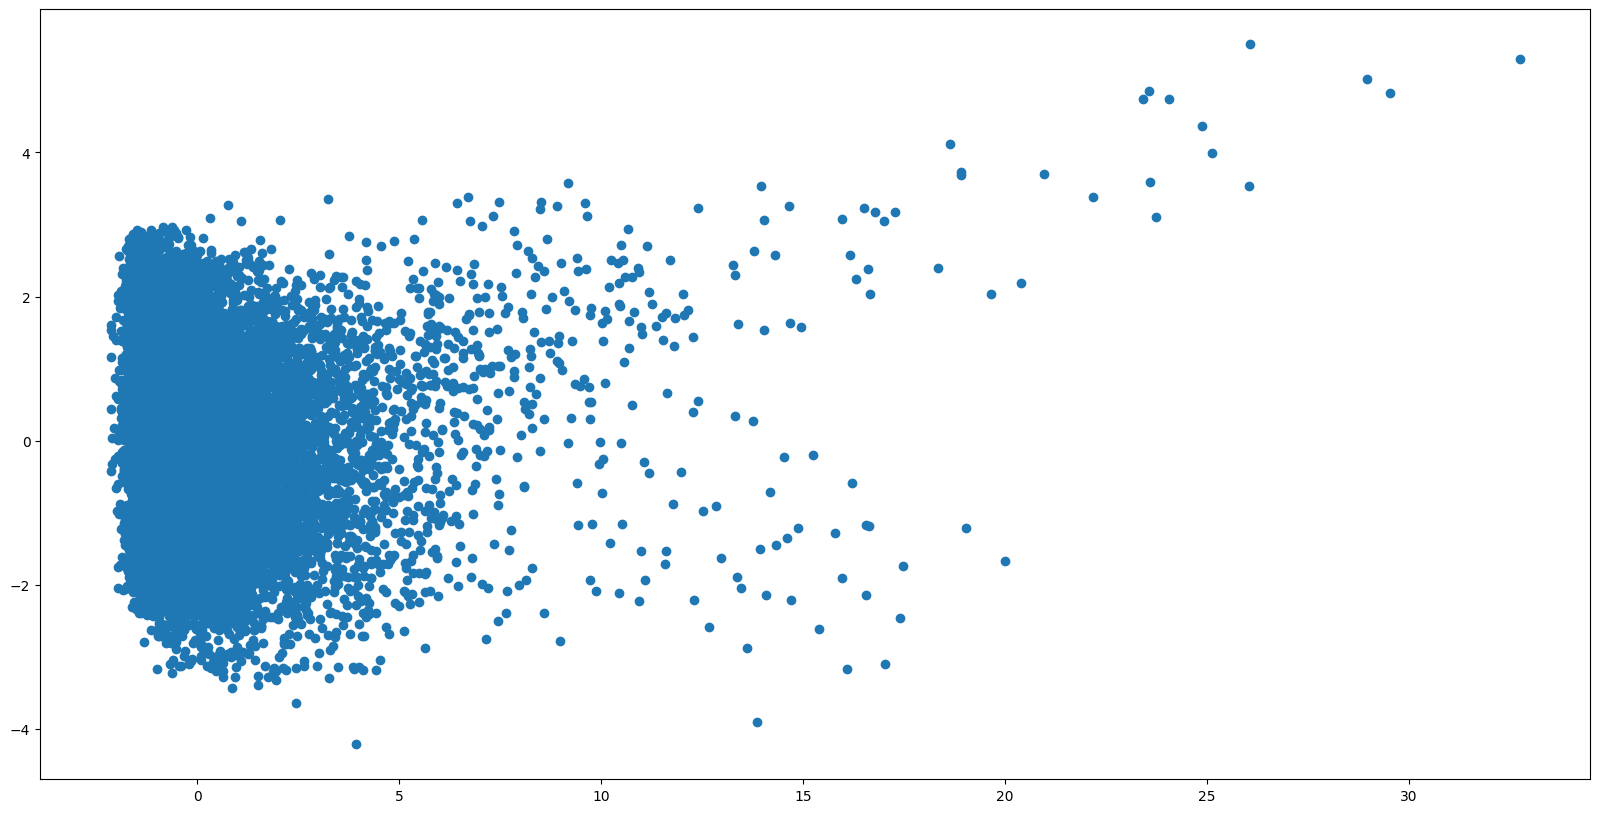

In [95]:
# plot pca
plt.figure(figsize=(20,10))
plt.scatter(df_incidents_agg_pca[:,0], df_incidents_agg_pca[:,1])
plt.show()